In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 5.0MB/s 
     |████████████████████████████████| 14.8MB 327kB/s 
     |████████████████████████████████| 6.5MB 35.6MB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%matplotlib inline
'''

Import Paths

'''

path = '/content/drive/MyDrive/data_challenge/'
acs_path = path + 'ACS/'
acs_dem_path = acs_path + 'Data_ACS_5Year_DemographicEstimateData.csv' # demographics
acs_soc_path = acs_path + 'Data_ACS_5Year_SocioeconomicEstimateData.csv' # socioeconomic
acs_hou_path = acs_path + 'Data_ACS_5Year_HousingEstimateData.csv' # housing
oz_path = path + 'Data_Lv5_HUD_OpportunityZones.csv'

shapefile_path = path + 'shapefiles/'
cb_path = shapefile_path + 'cb_2019/cb_2019_us_tract_500k.shp' # census tracts

'''

Clean and Import Datasets

'''

def import_acs(clean=True):
    dem = pd.read_csv(acs_dem_path)#, index_col='GEOID')
    soc = pd.read_csv(acs_soc_path, 'GEOID')
    hou = pd.read_csv(acs_hou_path, 'GEOID')
    
    if clean:
        # for df in [dem, soc, hou]:
            # df = zfill(remove_values(df))
        dem = zfill(remove_values(dem))
        soc = zfill(remove_values(soc))
        hou = zfill(remove_values(hou))
        
        dem = dem.rename({'B03002EST1': 'POP'})

    return dem, soc, hou

def import_dem(clean=True):
    dem = pd.read_csv(acs_dem_path)#, index_col='GEOID')
    
    if clean:
        dem = remove_values(dem)
        dem = zfill(dem)
        # dem = dem.rename({'B03002EST1': 'POP'})

    return dem

def import_soc(clean=True):
    soc = pd.read_csv(acs_soc_path)#, index_col='GEOID')
    
    if clean:
        soc = remove_values(soc)
        soc = zfill(soc)
        # dem = dem.rename({'B03002EST1': 'POP'})

    return soc

def import_hou(clean=True):
    hou = pd.read_csv(acs_hou_path)#, index_col='GEOID')
    
    if clean:
        hou = remove_values(hou)
        hou = zfill(hou)
        # dem = dem.rename({'B03002EST1': 'POP'})

    return hou

def zfill(df):
    df.STATE       = df.STATE.apply(lambda x: str(x).zfill(2))
    df.COUNTY      = df.COUNTY.apply(lambda x: str(x).zfill(3))
    df.TRACT       = df.TRACT.apply(lambda x: str(x).zfill(6))
    # df['CNTY_FIPS']= df['CNTY_FIPS'].apply(lambda x: str(x).zfill(5))
    df.GEOID       = df.GEOID.apply(lambda x: str(x).zfill(11)).astype(str)

    return df

def import_oz(clean=True):
    '''Import and clean Data_Lv5_HUD_OpportunityZones.csv'''
    df = pd.read_csv(oz_path)#, index_col='GEOID')
    if clean:
        # df = transform_designated(df)
        df = zfill(df)
        df = df.drop(['SHAPE_Length', 'SHAPE_Area'], axis=1) # 'Name'?
        df = remove_puerto_rico(df)

    return df

def import_cb():
    df = gpd.read_file(cb_path)#, index_col='GEOID')
    df = df.rename(columns={'TRACTCE': 'TRACT', 'STATEFP': 'STATE', 'COUNTYFP': 'COUNTY'}) # others?
    df = df.drop('AFFGEOID', axis=1)

    return df

def transform_designated(df):
    def designated(x):
        if x == True:
            return 'designated'
        elif x == False:
            return 'not designated'
        else: # implies x == np.nan
            return 'not eligible'

    df['cDESIGNATED'] = df.DESIGNATED.apply(designated).astype('category')

    return df

def eDESIGNATED(df):
    df['eDESIGNATED'] = df.DESIGNATED.apply(lambda x: True if x in [True, False] else False)

    return df

def remove_pct(df):
    cols = df.filter(like='PCT').columns
    df = df.drop(cols, axis=1)
    return df

def remove_values(df):
    cols = df.filter(like='_').columns
    cols = [col for col in cols if 'PCT' not in col]
    df = df.drop(cols, axis=1)
    return df

def remove_geo(df):
    df = df.drop(['SHAPE_Area', 'SHAPE_Length', 'GEOID', 'OBJECTID'], axis=1)
    return df

def remove_puerto_rico(df):
    return df[df.STATE != '72']

def remove_territories(df):
    # American Samoa, Puerto Rico
    return df[df.STATE.notin(['60', '72'])]

def import_all(clean=True, shapefile=False):
    # usage: oz, dem, soc, hou, cb = import_all()
    oz = import_oz(clean)
    dem, soc, hou = import_acs(clean)
    ret = [oz, dem, soc, hou]

    if shapefile:
        ret.append(import_cb_census(clean))
    
    return ret

def join_all(dfs):
    # return pd.join(dfs, on='GEOID') # or TRACT?
    df = dfs[0]
    for d in dfs[1:]:
        d = d.drop(['OBJECTID', 'GEOID', 'STATE', 'COUNTY', 'TRACT', 'NAME'], axis=1)
        df = df.join(d)
    
    return df

def merge_two(left, right, col='GEOID', **kwargs):
    duplicate_cols = list(set(left.columns).intersection(set(right.columns.drop(col))))
    right = right.drop(duplicate_cols, axis=1)
    df = left.merge(right, left_on=col, right_on=col)

    # if geo:
        # df = gpd.GeoDataFrame(gdf)

    return df

def merge_many(dfs, col='GEOID', **kwargs):
    df = dfs[0]
    for d in dfs[1:]:
        df = merge_two(df, d, col)

    return df

def merge_many_state(dfs, state='24', col='GEOID', **kwargs):
    ds = [df[df.STATE == state] for df in dfs]
    
    return merge_many(ds, col)

'''

Exploratory Analysis

'''

def oz_in_every_county(df, state) -> bool:
    counts = df[df.STATE == state].groupby('COUNTY').DESIGNATED.agg('sum')
    return bool(counts.count(0))

def percentage_eligible_oz_selected(df, state) -> float:
    counts = df.loc[df.STATE == state, 'DESIGNATED'].value_counts()
    return counts[True] / (counts[True] + counts[False]) if True in counts.index and False in counts.index else 1

def number_oz_selected(df, state) -> int:
    return df.loc[(df.STATE == state) & (df.DESIGNATED == True), 'TRACT'].nunique()

# Demographic

def get_educations_pct(df, tract):
    pass

def get_ages_pct(df, tract):
    # 0-17, 18-24, 25-64, 65+
    return df.loc[df.TRACT == tract, ['B01001_UNDER17_PCT', 'B01001_18TO24_PCT', 'B01001_25TO64_PCT', 'B01001_ABOVE65_PCT']]

def get_races_pct(df, tract):
    # White alone, Black or African American Alone, American Indian Alone, 
    #   Asian alone, Pacific Islander, Other, Two or more, Hispanic
    cols = [f'B03002EST{i}_PCT' for i in range(3, 9)]
    cols += ['B03002TMNH_PCT', 'B03002EST12_PCT']
    return df.loc[df.TRACT == tract, cols]

# Housing

def get_occupied_pct(df, tract):
    return df.loc[df.TRACT == tract, ['B25002EST2_PCT', 'B25002EST3_PCT']]


# needs fixing
def compare_acs_variable(df, state, feature, agg_method='mean'):
    return df[df.STATE == state].groupby('DESIGNATED')[feature].agg(agg_method)

def apply_all_states(df, fctn, **kwargs) -> dict:
    res = dict()
    for state in df.STATE.unique():
        res[state] = fctn(df, state, **kwargs)

    return res

def all_eligible(df, feature: str):
    feature_name = 'c' + feature
    df[feature_name] = df.apply(lambda row: 0 if row['DESIGNATED'] not in [True, False] else row[feature], axis=1)

    return df

'''

Data Analysis and Modeling

'''

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
import numpy as np



def prep_analysis(df):
    df = df[df.DESIGNATED.isin(True, False)]
    df = df.dropna(how='any')

    return df

def predict_oz(df):
    df = df[df.DESIGNATED.isin(True, False)]
    df = df.dropna(how='any')

def pca_predict_oz(df, n_components=20):
    df = prep_analysis(df)
    X_train, y_train, X_test, y_test = train_test_split(X, y)
    pca = PCA(n_components=20)
    components = pca.fit(X_train, y_train)

    return pca

def cluster_oz(df, include_eligible=True):
    if include_eligible:
        df = df[df.DESIGNATED.isin(True, False)]
    else:
        df = df[df.DESIGNATED == True]


'''

Plotting

'''

def plot_designated(gdf, **kwargs):
    df = transform_designated(gdf)
    return gdf.plot(column='cDESIGNATED', legend=True,
        categorical=True, **kwargs) # border='grey',

In [ ]:
oz = import_oz()

In [ ]:
cb = import_cb()

In [ ]:
dem = import_dem()

In [ ]:
hou = import_hou()

In [ ]:
soc = import_soc()

In [ ]:
md_dem_cb = merge_many_state([oz, dem, cb], '24', 'GEOID')
md_dem_cb.shape

(1395, 93)

In [ ]:
md_geo = gpd.GeoDataFrame(md_dem_cb)

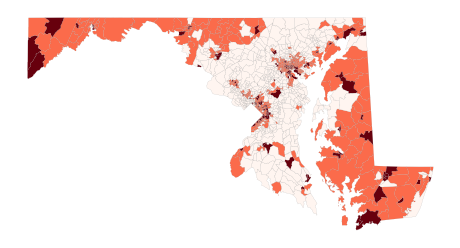

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot = md_geo.plot(column='cDESIGNATED', cmap='Reds_r', edgecolor='grey', linewidth=.1, ax=ax)
ax.axis('off')
plot

In [ ]:
md_geo = all_eligible(md_geo, 'B03002EST1')

In [ ]:
md_geo['cB03002EST1'].describe()

count     1395.000000
mean      2073.291039
std       2303.560783
min          0.000000
25%          0.000000
50%       1665.000000
75%       3793.500000
max      14953.000000
Name: cB03002EST1, dtype: float64

In [ ]:
pop_cutoff = md_geo.B03002EST1.quantile(.9)
md_geo.B03002EST1 = md_geo.B03002EST1.apply(lambda x: min(x, pop_cutoff))

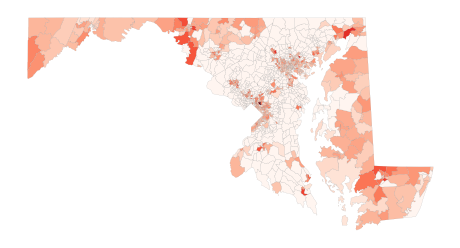

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot = md_geo.plot(column='cB03002EST1', cmap='Reds', edgecolor='grey', linewidth=.1, ax=ax)
ax.axis('off')
plot

In [ ]:
md_geo.groupby('cDESIGNATED')['B03002EST1'].describe()

,count,mean,std,min,25%,50%,75%,max
cDESIGNATED,,,,,,,,
designated,149.0,4018.442953,1995.253640,743.0,2539.00,3710.0,5211.00,14953.0
not designated,594.0,3861.099327,1613.045334,0.0,2693.25,3695.0,4816.25,10244.0
not eligible,652.0,4659.964724,1844.533973,0.0,3324.00,4468.0,5849.25,11579.0


In [ ]:
md_geo.groupby('cDESIGNATED')['B03002EST1'].agg('median')

cDESIGNATED
designated        3710
not designated    3695
not eligible      4468
Name: B03002EST1, dtype: int64

In [ ]:
age_cols = ['B01001_UNDER17', 'B01001_18TO24', 'B01001_25TO64', 'B01001_ABOVE64']
race_alone_cols = [f'B03002EST{i}' for i in range(3, 9)] + ['B03002TMNH', 'B03002EST12']

dem_features = age_cols + race_alone_cols
dem_features = [feature + '_PCT' for feature in dem_features]
dem_features += ['B03002EST1']

In [ ]:

soc_features = []


In [ ]:
hou_features = [] + + ['B25002EST1', 'B25002EST2']

In [ ]:
features = dem_features + soc_features + hou_features

In [ ]:
y_pred.shape

(733,)

In [ ]:
X, y = md_geo[dem_features], md_geo['cDESIGNATED']
X_train, X_test, y_train, y_test = train_test_split(X, y)
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6189111747851003

In [ ]:
from sklearn.metrics import plot_confusion_matrix

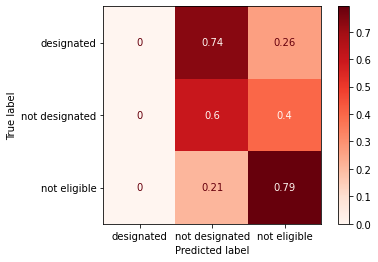

In [ ]:
plot_confusion_matrix(logreg, X_test, y_test, cmap='Reds', normalize='true') # colormap=False doesn't work

In [ ]:
us_geo = merge_two(oz, dem)
us_geo = us_geo[us_geo.STATE.notin('24', '06')]

In [ ]:
us_geo = transform_designated(us_geo)

In [ ]:
X_train, X_test = us_geo[dem_features], md_geo[dem_features] 
y_train, y_test = us_geo['cDESIGNATED'], md_geo['cDESIGNATED']

logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6315412186379928

In [ ]:
d_us_geo = us_geo.dropna(subset=['DESIGNATED', 'B25010EST1', 'B25010EST2', 'B25010EST3'])
d_md_geo = md_geo.dropna(subset=['DESIGNATED', 'B25010EST1', 'B25010EST2', 'B25010EST3'])

In [ ]:
us_geo.DESIGNATED.isna().sum()

30973

In [ ]:
X_train.shape, y_train.shape

((0, 70), (0,))

In [ ]:
X_test.shape, y_test.shape

((0, 75), (0,))

In [ ]:
d_us_geo.DESIGNATED = d_us_geo.DESIGNATED.astype(bool)
d_md_geo.DESIGNATED = d_md_geo.DESIGNATED.astype(bool)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
X_train, X_test = d_us_geo[dem_features], d_md_geo[dem_features] 
y_train, y_test = d_us_geo['DESIGNATED'], d_md_geo['DESIGNATED']
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7967257844474761

In [ ]:
y_test.sum() / y_test.shape[0]

0.20327421555252387

In [ ]:
y_train.sum() / y_train.shape[0]

0.18855985193337002

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
geo = gpd.GeoDataFrame(d_md_geo['geometry'])
geo['DESIGNATED'] = pd.Series(y_pred)

In [ ]:
geo['DESIGNATED'].value_counts()

False    358
Name: DESIGNATED, dtype: int64

In [ ]:
geo = transform_designated(geo)

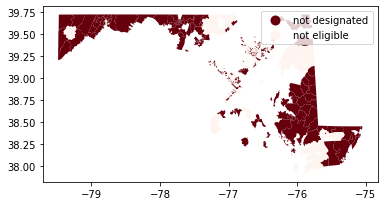

In [ ]:
geo.plot(column='cDESIGNATED', cmap='Reds_r', categorical=True, legend=True)

In [ ]:
ca = merge_many_state([oz, dem, cb], state='06', column='GEOID')

In [ ]:
ca = gpd.GeoDataFrame(ca)

In [ ]:
ca = transform_designated(ca)

In [ ]:
ca.groupby('cDESIGNATED')['B03002EST1'].describe()

,count,mean,std,min,25%,50%,75%,max
cDESIGNATED,,,,,,,,
designated,876.0,4676.453196,1885.381608,70.0,3342.00,4458.0,5836.75,14971.0
not designated,3464.0,4760.496247,1956.335082,0.0,3491.00,4573.5,5777.25,39454.0
not eligible,3698.0,4821.453488,2293.155757,0.0,3372.25,4518.0,5895.25,28187.0


In [ ]:
ca['cDESIGNATED'].value_counts()

not eligible      3698
not designated    3464
designated         876
Name: cDESIGNATED, dtype: int64

In [ ]:
ca.cDESIGNATED.dtype

CategoricalDtype(categories=['designated', 'not designated', 'not eligible'], ordered=False)

(-124.92351000000001, -113.617292, 32.06038954999999, 42.48325145)

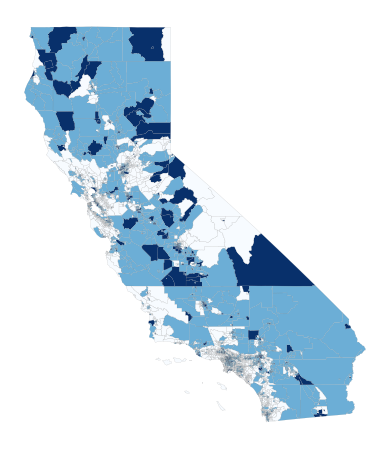

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot = ca.plot(column='cDESIGNATED', cmap='Blues_r', edgecolor='grey', linewidth=.1, ax=ax)
ax.axis('off')

In [ ]:
pop_cutoff = ca.B03002EST1.quantile(.9)
ca.B03002EST1 = ca.B03002EST1.apply(lambda x: min(x, pop_cutoff))

In [ ]:
ca = all_eligible(ca, 'B03002EST1')

In [ ]:
ca.B03002EST1.quantile(.9)

7165.0

In [ ]:
ca.cB03002EST1.describe()

count     8038.000000
mean      2561.200796
std       2761.665101
min          0.000000
25%          0.000000
50%       2398.500000
75%       4714.000000
max      39454.000000
Name: cB03002EST1, dtype: float64

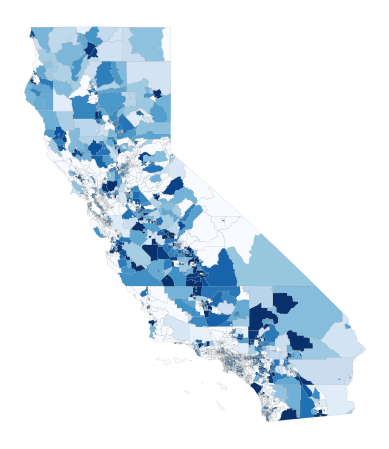

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot = ca.plot(column='cB03002EST1', cmap='Blues', edgecolor='grey', linewidth=.1, ax=ax)
ax.axis('off')
plot

In [ ]:
ca.DESIGNATED.dtype

dtype('O')

In [ ]:
ca.cDESIGNATED.value_counts()

not eligible      3698
not designated    3464
designated         876
Name: cDESIGNATED, dtype: int64

# Predictive Model

In [ ]:
all_data_const = merge_many([oz, soc, hou, dem, cb])
# all_data = gpd.GeoDataFrame(all_data)

In [ ]:
all_data = all_data_const

In [ ]:
# dropna while keeping DESIGNATED column
all_data = all_data.dropna(subset=['DESIGNATED'])
all_data = all_data.dropna(axis=1)

# make bool
all_data.DESIGNATED = all_data.DESIGNATED.astype(bool)

column selection / deletion

In [ ]:
age_cols = ['B01001_UNDER17', 'B01001_18TO24', 'B01001_25TO64', 'B01001_ABOVE64']
race_alone_cols = [f'B03002EST{i}' for i in range(3, 9)] + ['B03002TMNH', 'B03002EST12']

dem_features = age_cols + race_alone_cols
dem_features = [feature + '_PCT' for feature in dem_features]
dem_features += ['B03002EST1']

In [ ]:
rem_cols = ['OBJECTID', 'GEOID', 'COUNTY', 'TRACT', 'NAME',
       'LIC', 'CONTIGUOUS', 'FID', 'STUSAB', 'LSAD'] # cannot remove state or geometry until after assign md_all, ca_all
       # 'EACODE', 'EANAME', 'SUBTRACTIONS', 'ADDITIONS' removed at dropna(axis=1)

try removing columns

In [ ]:
all_data = remove_values(all_data)
all_data = all_data.drop(rem_cols, axis=1)

# after cleaned, remove and set md and ca dfs
md_all = all_data[all_data.STATE == '24']
all_data = all_data.drop(md_all.index)
ca_all = all_data[all_data.STATE == '06']
all_data = all_data.drop(ca_all.index)

md_geo = gpd.GeoDataFrame(md_all['geometry'])
ca_geo = gpd.GeoDataFrame(ca_all['geometry'])

all_data = all_data.drop(['geometry', 'STATE'], axis=1)
md_all = md_all.drop(['geometry', 'STATE'], axis=1)
ca_all = ca_all.drop(['geometry', 'STATE'], axis=1)

all_data = all_data.select_dtypes(include=[int, float, bool])
md_all = md_all.select_dtypes(include=[int, float, bool])
ca_all = ca_all.select_dtypes(include=[int, float, bool])

# anything extra
# all_data = all_data.drop([''], axis=1)

In [ ]:
# all_data.isna().sum().sort_values(ascending=False).head(20)
# all_data.isna().sum().nunique()
# all_data.dropna(axis=1).isna().sum().nunique()

array([0])

In [ ]:
# all_data = remove_values(all_data)
# all_data = all_data.drop(rem_cols, axis=1)
'DESIGNATED' in all_data.columns

True

run model for md

In [ ]:
X_train, X_test = all_data.drop('DESIGNATED', axis=1), md_all.drop('DESIGNATED', axis=1)
y_train, y_test = all_data['DESIGNATED'], md_all['DESIGNATED']
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Recall:', recall_score(y_test, y_pred))
logreg.score(X_test, y_test)

0.7806191117092867

using gridsearchcv

In [ ]:
grid={"C":np.logspace(-3,3,7)}#, "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)

logreg_cv.fit(X_train, y_train)
y_pred_cv = logreg_cv.predict(X_test)
print('Recall:', recall_score(y_test, y_pred_cv))
logreg_cv.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

Recall: 0.08053691275167785


0.7806191117092867

plot predictions

In [ ]:
y_pred.shape

(36103,)

In [ ]:
md_geo.cDESIGNATED.value_counts()

not designated    705
designated         38
Name: cDESIGNATED, dtype: int64

(-79.7095866, -74.82700340000001, 37.82115069999999, 39.81360929999999)

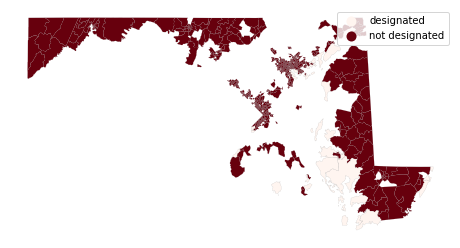

In [ ]:
# md_geo['DESIGNATED'] = all_data.loc[all_data.STATE == '24', 'DESIGNATED'].astype(bool)
y_pred = logreg.predict(X_test)
md_geo['DESIGNATED'] = y_pred
# md_geo = md_geo.dropna()
md_geo.DESIGNATED = md_geo.DESIGNATED.astype(bool)
md_geo = transform_designated(md_geo)

fig, ax = plt.subplots(figsize=(8,8))
md_geo.plot(column='cDESIGNATED', cmap='Reds', categorical=True, legend=True, edgecolor='grey', linewidth=.1, ax=ax)
ax.axis('off')
# md_geo.plot(column='DESIGNATED', categorical=True, cmap='Reds_r')

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plot_confusion_matrix(logreg, X_test, y_test, cmap='Reds', normalize='true')

# Population

In [ ]:
md_corr = md_geo[['DESIGNATED', 'B03002EST1']].dropna()
md_corr.DESIGNATED = md_corr.DESIGNATED.astype(bool)
md_corr.corr()

,DESIGNATED,B03002EST1
DESIGNATED,1.00000,0.02221
B03002EST1,0.02221,1.00000


In [ ]:
ca_corr = ca[['DESIGNATED', 'B03002EST1']].dropna()
ca_corr.DESIGNATED = ca_corr.DESIGNATED.astype(bool)
ca_corr.corr()

,DESIGNATED,B03002EST1
DESIGNATED,1.000000,-0.017553
B03002EST1,-0.017553,1.000000


# Affordable Housing

In [ ]:
md_soc_hou = merge_many_state([oz, hou, soc, cb], '24', 'GEOID')
md_soc_hou.shape

(1395, 301)

In [ ]:
md_soc_hou.B25002EST2_PCT.describe()

count    1395.000000
mean       90.019068
std        11.871867
min         0.000000
25%        88.215000
50%        93.040000
75%        96.300000
max       100.000000
Name: B25002EST2_PCT, dtype: float64

In [ ]:
md_soc_hou = gpd.GeoDataFrame(md_soc_hou)

In [ ]:
md_soc_hou = all_eligible(md_soc_hou, 'B25002EST2_PCT')

(-79.7095866, -74.82700340000001, 37.82115069999999, 39.81360929999999)

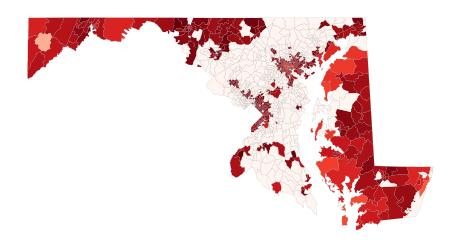

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
md_soc_hou.plot(column='cB25002EST2_PCT', cmap='Reds', edgecolor='grey', linewidth=.1, ax=ax)
ax.axis('off')


In [ ]:
md_soc_hou = 

In [ ]:
md_aff_corr = md_soc_hou[['cB25002EST2_PCT', 'DESIGNATED']].dropna()
md_aff_corr.DESIGNATED = md_aff_corr.DESIGNATED.astype(bool)
md_aff_corr.corr()

,cB25002EST2_PCT,DESIGNATED
cB25002EST2_PCT,1.000000,-0.130047
DESIGNATED,-0.130047,1.000000


In [ ]:
md_jobs = md_soc_hou[['DESIGNATED', 'C24010_SERVICE_PCT', 'C24010_SALES_PCT', 
                      'C24010_FARM_PCT', 'C24010_CEMR_PCT', 'C24010_PTM_PCT']].dropna()
md_jobs.DESIGNATED = md_jobs.DESIGNATED.astype(bool)
md_jobs.corr()['DESIGNATED']

DESIGNATED            1.000000
C24010_SERVICE_PCT    0.123322
C24010_SALES_PCT      0.071671
C24010_FARM_PCT      -0.019424
C24010_CEMR_PCT      -0.054428
C24010_PTM_PCT        0.034443
Name: DESIGNATED, dtype: float64